In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score,accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [3]:
with open(r"data/NER_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/NER_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/NER_Test.json', 'r') as f:
    test_data = json.load(f)

In [4]:
model = fasttext.load_model("cc.en.300.bin")

In [5]:
word_embedding = model.get_word_vector('hello')
print(word_embedding)

[ 1.57576188e-01  4.37820926e-02 -4.51271934e-03  6.65931404e-02
  7.70346820e-02  4.85855248e-03  8.19822028e-03  6.52402919e-03
  9.25899856e-03  3.53899002e-02 -2.31395271e-02 -4.91807126e-02
 -8.32642540e-02  1.56014524e-02  2.54856616e-01  3.45423706e-02
 -1.07451361e-02 -7.80188590e-02 -7.08099529e-02  7.62385577e-02
 -6.09613657e-02  4.48625796e-02 -7.29744136e-02  1.30583309e-02
  3.14881057e-02 -3.10055036e-02  1.66004002e-02  1.74405202e-02
 -7.35838860e-02  1.18252613e-01 -1.21330231e-01 -4.09253240e-02
  2.93969568e-02  4.84445989e-02 -1.33816330e-02 -1.74765270e-02
  7.51308873e-02  9.97046307e-02 -4.00476977e-02  4.05735290e-03
 -7.21896589e-02 -4.43356819e-02 -1.22628408e-03  7.56693557e-02
  3.98401320e-02  3.22643593e-02  1.95914153e-02  4.68016043e-02
 -1.46228177e-02  1.12967767e-01  3.15065160e-02 -1.02312110e-01
  1.58124104e-01 -2.76147053e-02 -3.39851156e-02 -1.77006852e-02
 -5.73529862e-04  1.10789239e-01 -1.64533369e-02 -3.14955460e-03
 -4.22914140e-02  1.11429

In [6]:
def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
                embedding.append(model.get_word_vector(word))
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 70 # maximum length of word in 1 text 
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(model.get_word_vector("Hello"))] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [7]:

x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_44711/937020881.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [8]:
x_train.size()

torch.Size([8019, 70, 300])

In [9]:
# unique_labels = set()
# for example in train_data.values():
#     unique_labels.update(example['labels'])
# for example in test_data.values():
#     unique_labels.update(example['labels'])
# for example in val_data.values():
#     unique_labels.update(example['labels'])
# unique_labels.remove('O')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# label_to_index['O'] = max(label_to_index.values()) +1
# print((label_to_index))

In [10]:
def convert_labels_to_fixed_length(labels, max_length):
    label_to_index = {'I_WITNESS': 0, 'B_JUDGE': 1, 'I_CASE_NUMBER': 2, 'B_CASE_NUMBER': 3, 'I_PROVISION': 4, 'B_STATUTE': 5, 'I_DATE': 6, 'I_STATUTE': 7, 'B_WITNESS': 8, 'B_DATE': 9, 'I_RESPONDENT': 10, 'B_PRECEDENT': 11, 'B_GPE': 12, 'I_ORG': 13, 'I_PETITIONER': 14, 'B_PROVISION': 15, 'B_ORG': 16, 'I_JUDGE': 17, 'I_OTHER_PERSON': 18, 'B_COURT': 19, 'B_PETITIONER': 20, 'B_RESPONDENT': 21, 'I_PRECEDENT': 22, 'I_COURT': 23, 'I_GPE': 24, 'B_OTHER_PERSON': 25, 'O': 26, '<pad>':27}
    new_list=[]
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 27
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 70
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [11]:
y_train.size()

torch.Size([8019, 70])

In [12]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


/home/bsumit43/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [13]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMTagger, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 28
learning_rate = 0.001
num_epochs = 130
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = LSTMTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")


/tmp/ipykernel_44711/3454487086.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_44711/3454487086.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_44711/3454487086.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_44711/3454487086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/130, Train Loss: 1.5495884569864424, Val Loss: 0.9488152265548706, Val F1: 0.03389261468057813, Train F1: 0.032291487516384


  2%|▋                                          | 2/130 [00:09<10:16,  4.82s/it]

Epoch 2/130, Train Loss: 0.8765757244730753, Val Loss: 0.7933934926986694, Val F1: 0.04786238116244543, Train F1: 0.038759970995866144


  2%|▉                                          | 3/130 [00:14<10:04,  4.76s/it]

Epoch 3/130, Train Loss: 0.7559832514278473, Val Loss: 0.7102535367012024, Val F1: 0.0581424574467603, Train F1: 0.05486627483288634


  3%|█▎                                         | 4/130 [00:19<09:57,  4.74s/it]

Epoch 4/130, Train Loss: 0.6882639413788205, Val Loss: 0.6484038233757019, Val F1: 0.05941167855199762, Train F1: 0.05943668722278691


  4%|█▋                                         | 5/130 [00:23<09:53,  4.75s/it]

Epoch 5/130, Train Loss: 0.6295534060114906, Val Loss: 0.5939916968345642, Val F1: 0.07089049318742477, Train F1: 0.06512023695813814


  5%|█▉                                         | 6/130 [00:28<09:47,  4.74s/it]

Epoch 6/130, Train Loss: 0.5810677021268814, Val Loss: 0.5513778328895569, Val F1: 0.11003424335773643, Train F1: 0.0883937769044394


  5%|██▎                                        | 7/130 [00:33<09:40,  4.72s/it]

Epoch 7/130, Train Loss: 0.5440018077691396, Val Loss: 0.5202023386955261, Val F1: 0.13882206324041851, Train F1: 0.12064714518190559


  6%|██▋                                        | 8/130 [00:38<09:39,  4.75s/it]

Epoch 8/130, Train Loss: 0.5154967643911876, Val Loss: 0.49916157126426697, Val F1: 0.153009327373358, Train F1: 0.1499780989022041


  7%|██▉                                        | 9/130 [00:42<09:31,  4.72s/it]

Epoch 9/130, Train Loss: 0.4934445383056762, Val Loss: 0.47652244567871094, Val F1: 0.1980225240686286, Train F1: 0.1749463356391276


  8%|███▏                                      | 10/130 [00:47<09:21,  4.68s/it]

Epoch 10/130, Train Loss: 0.4765633349380796, Val Loss: 0.4653629660606384, Val F1: 0.22563560328670929, Train F1: 0.2052029117395324


  8%|███▌                                      | 11/130 [00:51<09:14,  4.66s/it]

Epoch 11/130, Train Loss: 0.4628081236566816, Val Loss: 0.4510892927646637, Val F1: 0.22695423422703756, Train F1: 0.22416003543280205


  9%|███▉                                      | 12/130 [00:56<09:09,  4.66s/it]

Epoch 12/130, Train Loss: 0.4504986320223127, Val Loss: 0.44672462344169617, Val F1: 0.24617968875602045, Train F1: 0.2359986782689055


 10%|████▏                                     | 13/130 [01:01<09:06,  4.67s/it]

Epoch 13/130, Train Loss: 0.44032999305498033, Val Loss: 0.4342310130596161, Val F1: 0.24502230278926276, Train F1: 0.24643904744952666


 11%|████▌                                     | 14/130 [01:05<09:01,  4.67s/it]

Epoch 14/130, Train Loss: 0.43397908030994353, Val Loss: 0.4299326241016388, Val F1: 0.24482503240646453, Train F1: 0.2528683063064379


 12%|████▊                                     | 15/130 [01:10<08:58,  4.68s/it]

Epoch 15/130, Train Loss: 0.424842463599311, Val Loss: 0.4201022982597351, Val F1: 0.26244072222096526, Train F1: 0.25821380971555213


 12%|█████▏                                    | 16/130 [01:15<08:55,  4.69s/it]

Epoch 16/130, Train Loss: 0.41810006328991484, Val Loss: 0.41711047291755676, Val F1: 0.2521972934152072, Train F1: 0.2659031989738226


 13%|█████▍                                    | 17/130 [01:20<08:49,  4.69s/it]

Epoch 17/130, Train Loss: 0.41179553667704266, Val Loss: 0.4115307629108429, Val F1: 0.2726279761109716, Train F1: 0.274688496900584


 14%|█████▊                                    | 18/130 [01:24<08:45,  4.70s/it]

Epoch 18/130, Train Loss: 0.4050255200219533, Val Loss: 0.4081389009952545, Val F1: 0.2778017621713269, Train F1: 0.28017020514418367


 15%|██████▏                                   | 19/130 [01:29<08:48,  4.77s/it]

Epoch 19/130, Train Loss: 0.40364138569150654, Val Loss: 0.40721428394317627, Val F1: 0.2835102353219636, Train F1: 0.28419883453132216


 15%|██████▍                                   | 20/130 [01:34<08:48,  4.81s/it]

Epoch 20/130, Train Loss: 0.3990088758014497, Val Loss: 0.4031934440135956, Val F1: 0.28780007994282214, Train F1: 0.29139189892673023


 16%|██████▊                                   | 21/130 [01:39<08:42,  4.80s/it]

Epoch 21/130, Train Loss: 0.39273951592899503, Val Loss: 0.39868471026420593, Val F1: 0.28169911677683634, Train F1: 0.2973576176834711


 17%|███████                                   | 22/130 [01:44<08:34,  4.76s/it]

Epoch 22/130, Train Loss: 0.3907183692568824, Val Loss: 0.4010061025619507, Val F1: 0.27265421529409267, Train F1: 0.2987396182656507


 18%|███████▍                                  | 23/130 [01:48<08:27,  4.75s/it]

Epoch 23/130, Train Loss: 0.3834038036210196, Val Loss: 0.3922657370567322, Val F1: 0.30592144428463314, Train F1: 0.30643761432968386


 18%|███████▊                                  | 24/130 [01:53<08:21,  4.73s/it]

Epoch 24/130, Train Loss: 0.37943716749312384, Val Loss: 0.39051496982574463, Val F1: 0.312158211623015, Train F1: 0.3123995666847125


 19%|████████                                  | 25/130 [01:58<08:15,  4.72s/it]

Epoch 25/130, Train Loss: 0.3771599734586383, Val Loss: 0.38857460021972656, Val F1: 0.3052787252768894, Train F1: 0.3137876607895275


 20%|████████▍                                 | 26/130 [02:02<08:10,  4.71s/it]

Epoch 26/130, Train Loss: 0.3733577411326151, Val Loss: 0.3864753544330597, Val F1: 0.31020753273915447, Train F1: 0.32021886918025444


 21%|████████▋                                 | 27/130 [02:07<08:04,  4.71s/it]

Epoch 27/130, Train Loss: 0.3697190388800606, Val Loss: 0.38336488604545593, Val F1: 0.3177144547437615, Train F1: 0.32217229669528885


 22%|█████████                                 | 28/130 [02:12<07:59,  4.70s/it]

Epoch 28/130, Train Loss: 0.3665678941068195, Val Loss: 0.3862275779247284, Val F1: 0.30974579320731166, Train F1: 0.32883400120413686


 22%|█████████▎                                | 29/130 [02:16<07:54,  4.70s/it]

Epoch 29/130, Train Loss: 0.36265411878389026, Val Loss: 0.38058704137802124, Val F1: 0.3237772973040385, Train F1: 0.333613385035365


 23%|█████████▋                                | 30/130 [02:21<07:51,  4.72s/it]

Epoch 30/130, Train Loss: 0.3597048658227164, Val Loss: 0.37801042199134827, Val F1: 0.32602907870008646, Train F1: 0.33706815791631234


 24%|██████████                                | 31/130 [02:26<07:48,  4.73s/it]

Epoch 31/130, Train Loss: 0.35669406775444273, Val Loss: 0.3802289068698883, Val F1: 0.3166523043418091, Train F1: 0.34175048338160796


 25%|██████████▎                               | 32/130 [02:31<07:42,  4.72s/it]

Epoch 32/130, Train Loss: 0.3559809412275042, Val Loss: 0.37530192732810974, Val F1: 0.333440241177644, Train F1: 0.34177495432161115


 25%|██████████▋                               | 33/130 [02:35<07:39,  4.74s/it]

Epoch 33/130, Train Loss: 0.3507463752277314, Val Loss: 0.37910306453704834, Val F1: 0.316416239780353, Train F1: 0.3497079071693249


 26%|██████████▉                               | 34/130 [02:40<07:33,  4.72s/it]

Epoch 34/130, Train Loss: 0.3487119324623592, Val Loss: 0.3756159245967865, Val F1: 0.3315886565931755, Train F1: 0.3584548208150328


 27%|███████████▎                              | 35/130 [02:45<07:28,  4.72s/it]

Epoch 35/130, Train Loss: 0.34501209996995474, Val Loss: 0.3752180337905884, Val F1: 0.3377101344020152, Train F1: 0.3593758736619158


 28%|███████████▋                              | 36/130 [02:49<07:22,  4.71s/it]

Epoch 36/130, Train Loss: 0.34255971795036677, Val Loss: 0.3729948401451111, Val F1: 0.33839307885125663, Train F1: 0.36041824003938444


 28%|███████████▉                              | 37/130 [02:54<07:17,  4.70s/it]

Epoch 37/130, Train Loss: 0.3391857071528359, Val Loss: 0.37151145935058594, Val F1: 0.3440212235442076, Train F1: 0.3701745310695189


 29%|████████████▎                             | 38/130 [02:59<07:12,  4.70s/it]

Epoch 38/130, Train Loss: 0.3370963486414107, Val Loss: 0.3776693046092987, Val F1: 0.34041663987179804, Train F1: 0.37053149045958594


 30%|████████████▌                             | 39/130 [03:04<07:08,  4.71s/it]

Epoch 39/130, Train Loss: 0.33647715856158544, Val Loss: 0.37176424264907837, Val F1: 0.34289265734618724, Train F1: 0.3731397875611878


 31%|████████████▉                             | 40/130 [03:08<07:04,  4.71s/it]

Epoch 40/130, Train Loss: 0.3323602316871522, Val Loss: 0.37503960728645325, Val F1: 0.3378025612171452, Train F1: 0.37896841585522295


 32%|█████████████▏                            | 41/130 [03:13<06:59,  4.71s/it]

Epoch 41/130, Train Loss: 0.3299585046276214, Val Loss: 0.3720603585243225, Val F1: 0.3501446540451317, Train F1: 0.385741482003653


 32%|█████████████▌                            | 42/130 [03:18<06:57,  4.75s/it]

Epoch 42/130, Train Loss: 0.32600546356231447, Val Loss: 0.3712576925754547, Val F1: 0.34169544925467976, Train F1: 0.3871366034534055


 33%|█████████████▉                            | 43/130 [03:23<06:51,  4.73s/it]

Epoch 43/130, Train Loss: 0.3239804378577641, Val Loss: 0.36875680088996887, Val F1: 0.36118854103320985, Train F1: 0.395547154858008


 34%|██████████████▏                           | 44/130 [03:27<06:46,  4.73s/it]

Epoch 44/130, Train Loss: 0.322723085445071, Val Loss: 0.3729056417942047, Val F1: 0.3514683238933014, Train F1: 0.3911860970772861


 35%|██████████████▌                           | 45/130 [03:32<06:41,  4.72s/it]

Epoch 45/130, Train Loss: 0.32055461690539405, Val Loss: 0.3696483373641968, Val F1: 0.3596032884636449, Train F1: 0.3950981385078469


 35%|██████████████▊                           | 46/130 [03:37<06:34,  4.70s/it]

Epoch 46/130, Train Loss: 0.3179332131431216, Val Loss: 0.3714551031589508, Val F1: 0.37500129824356254, Train F1: 0.4006836704852026


 36%|███████████████▏                          | 47/130 [03:41<06:29,  4.70s/it]

Epoch 47/130, Train Loss: 0.31465886367691887, Val Loss: 0.37219545245170593, Val F1: 0.3624909126379182, Train F1: 0.4071846775567953


 37%|███████████████▌                          | 48/130 [03:46<06:24,  4.68s/it]

Epoch 48/130, Train Loss: 0.31224636142216033, Val Loss: 0.3691500723361969, Val F1: 0.3663167476037052, Train F1: 0.408546016439773


 38%|███████████████▊                          | 49/130 [03:51<06:21,  4.71s/it]

Epoch 49/130, Train Loss: 0.31004570921262103, Val Loss: 0.37825727462768555, Val F1: 0.3562877966285114, Train F1: 0.4111878704221752


 38%|████████████████▏                         | 50/130 [03:56<06:19,  4.75s/it]

Epoch 50/130, Train Loss: 0.3083382315105862, Val Loss: 0.37118464708328247, Val F1: 0.3728932528889414, Train F1: 0.41799828690436736


 39%|████████████████▍                         | 51/130 [04:00<06:13,  4.73s/it]

Epoch 51/130, Train Loss: 0.30573441584904987, Val Loss: 0.37084248661994934, Val F1: 0.36524568870935625, Train F1: 0.4164330864942856


 40%|████████████████▊                         | 52/130 [04:05<06:10,  4.74s/it]

Epoch 52/130, Train Loss: 0.30385179368276444, Val Loss: 0.3740560710430145, Val F1: 0.3685947152747289, Train F1: 0.4198877315304156


 41%|█████████████████                         | 53/130 [04:10<06:05,  4.75s/it]

Epoch 53/130, Train Loss: 0.30072419723821064, Val Loss: 0.372643381357193, Val F1: 0.3713326385708965, Train F1: 0.4275262409694739


 42%|█████████████████▍                        | 54/130 [04:14<05:59,  4.73s/it]

Epoch 54/130, Train Loss: 0.29851278473460485, Val Loss: 0.38219019770622253, Val F1: 0.3582441146348658, Train F1: 0.4337990521825955


 42%|█████████████████▊                        | 55/130 [04:19<05:53,  4.71s/it]

Epoch 55/130, Train Loss: 0.29765965493898544, Val Loss: 0.370156854391098, Val F1: 0.3723983421238779, Train F1: 0.435253689387441


 43%|██████████████████                        | 56/130 [04:24<05:47,  4.70s/it]

Epoch 56/130, Train Loss: 0.29365088258470806, Val Loss: 0.3752427101135254, Val F1: 0.3756572191067202, Train F1: 0.43786878961456677


 44%|██████████████████▍                       | 57/130 [04:29<05:42,  4.70s/it]

Epoch 57/130, Train Loss: 0.2914110128841703, Val Loss: 0.38192224502563477, Val F1: 0.36734532303686157, Train F1: 0.4436475871225809


 45%|██████████████████▋                       | 58/130 [04:33<05:37,  4.69s/it]

Epoch 58/130, Train Loss: 0.2915918065441979, Val Loss: 0.38338884711265564, Val F1: 0.3640075348679829, Train F1: 0.4441875176708752


 45%|███████████████████                       | 59/130 [04:38<05:32,  4.69s/it]

Epoch 59/130, Train Loss: 0.289579170327338, Val Loss: 0.3769204616546631, Val F1: 0.3749334414805052, Train F1: 0.44930505084679384


 46%|███████████████████▍                      | 60/130 [04:43<05:28,  4.69s/it]

Epoch 60/130, Train Loss: 0.29026222678404007, Val Loss: 0.3858218491077423, Val F1: 0.373034902332792, Train F1: 0.44697709639766353


 47%|███████████████████▋                      | 61/130 [04:47<05:23,  4.69s/it]

Epoch 61/130, Train Loss: 0.2854228038636465, Val Loss: 0.37529894709587097, Val F1: 0.37844173433859607, Train F1: 0.452288373465616


 48%|████████████████████                      | 62/130 [04:52<05:18,  4.69s/it]

Epoch 62/130, Train Loss: 0.2827915180297125, Val Loss: 0.37621304392814636, Val F1: 0.3833060701127881, Train F1: 0.4594167509467602


 48%|████████████████████▎                     | 63/130 [04:57<05:13,  4.68s/it]

Epoch 63/130, Train Loss: 0.28016526334815556, Val Loss: 0.3752332329750061, Val F1: 0.3798543725345074, Train F1: 0.4625917171289982


 49%|████████████████████▋                     | 64/130 [05:01<05:10,  4.71s/it]

Epoch 64/130, Train Loss: 0.28414564284067306, Val Loss: 0.38514837622642517, Val F1: 0.39452391988492724, Train F1: 0.4582061229009184


 50%|█████████████████████                     | 65/130 [05:06<05:05,  4.70s/it]

Epoch 65/130, Train Loss: 0.2807553081758439, Val Loss: 0.3760782480239868, Val F1: 0.3856960449490696, Train F1: 0.46303369480947404


 51%|█████████████████████▎                    | 66/130 [05:11<05:00,  4.69s/it]

Epoch 66/130, Train Loss: 0.2740257387123411, Val Loss: 0.3779371380805969, Val F1: 0.3913666020886439, Train F1: 0.4712527942780731


 52%|█████████████████████▋                    | 67/130 [05:15<04:55,  4.69s/it]

Epoch 67/130, Train Loss: 0.27190760818738785, Val Loss: 0.3791618049144745, Val F1: 0.38421453423387686, Train F1: 0.4789318355793689


 52%|█████████████████████▉                    | 68/130 [05:20<04:50,  4.69s/it]

Epoch 68/130, Train Loss: 0.2693574982030051, Val Loss: 0.3904166519641876, Val F1: 0.39327975692945033, Train F1: 0.47634746321517996


 53%|██████████████████████▎                   | 69/130 [05:25<04:46,  4.70s/it]

Epoch 69/130, Train Loss: 0.26716233506089165, Val Loss: 0.38936829566955566, Val F1: 0.39403334254923417, Train F1: 0.48146455560567636


 54%|██████████████████████▌                   | 70/130 [05:30<04:41,  4.69s/it]

Epoch 70/130, Train Loss: 0.2643431332849321, Val Loss: 0.39477628469467163, Val F1: 0.3903495589968327, Train F1: 0.49297280652457065


 55%|██████████████████████▉                   | 71/130 [05:34<04:36,  4.69s/it]

Epoch 71/130, Train Loss: 0.2631930543316735, Val Loss: 0.39736658334732056, Val F1: 0.40456555022701335, Train F1: 0.4859581519209683


 55%|███████████████████████▎                  | 72/130 [05:39<04:31,  4.68s/it]

Epoch 72/130, Train Loss: 0.26099782567175606, Val Loss: 0.39205148816108704, Val F1: 0.3910338982315525, Train F1: 0.494371979993967


 56%|███████████████████████▌                  | 73/130 [05:44<04:27,  4.69s/it]

Epoch 73/130, Train Loss: 0.25902100072966683, Val Loss: 0.39793336391448975, Val F1: 0.40436348996725935, Train F1: 0.5029259411120951


 57%|███████████████████████▉                  | 74/130 [05:48<04:22,  4.69s/it]

Epoch 74/130, Train Loss: 0.2593725794364536, Val Loss: 0.3852836787700653, Val F1: 0.3826012841727613, Train F1: 0.49354309916882555


 58%|████████████████████████▏                 | 75/130 [05:53<04:19,  4.73s/it]

Epoch 75/130, Train Loss: 0.2564769888681079, Val Loss: 0.39027994871139526, Val F1: 0.384996292313759, Train F1: 0.5034315263989053


 58%|████████████████████████▌                 | 76/130 [05:58<04:15,  4.72s/it]

Epoch 76/130, Train Loss: 0.2552755881869604, Val Loss: 0.40241241455078125, Val F1: 0.39981391779830266, Train F1: 0.5006324312230018


 59%|████████████████████████▉                 | 77/130 [06:02<04:10,  4.72s/it]

Epoch 77/130, Train Loss: 0.2511262496312459, Val Loss: 0.4105723202228546, Val F1: 0.3930010514820964, Train F1: 0.5094377909914377


 60%|█████████████████████████▏                | 78/130 [06:07<04:05,  4.72s/it]

Epoch 78/130, Train Loss: 0.24814713568914504, Val Loss: 0.40495356917381287, Val F1: 0.38319721370696763, Train F1: 0.5169504972385435


 61%|█████████████████████████▌                | 79/130 [06:12<04:00,  4.71s/it]

Epoch 79/130, Train Loss: 0.24710678391986424, Val Loss: 0.40641072392463684, Val F1: 0.40380409160174263, Train F1: 0.5138476677519722


 62%|█████████████████████████▊                | 80/130 [06:17<03:54,  4.70s/it]

Epoch 80/130, Train Loss: 0.244954433942598, Val Loss: 0.4138426184654236, Val F1: 0.3913568426718258, Train F1: 0.5208972751906958


 62%|██████████████████████████▏               | 81/130 [06:21<03:49,  4.69s/it]

Epoch 81/130, Train Loss: 0.24291114414495135, Val Loss: 0.42393845319747925, Val F1: 0.39141906128709747, Train F1: 0.5266922763841941


 63%|██████████████████████████▍               | 82/130 [06:26<03:45,  4.70s/it]

Epoch 82/130, Train Loss: 0.24202827588906364, Val Loss: 0.41791778802871704, Val F1: 0.39469216679003455, Train F1: 0.5269071668875364


 64%|██████████████████████████▊               | 83/130 [06:31<03:40,  4.69s/it]

Epoch 83/130, Train Loss: 0.24087955175884188, Val Loss: 0.4180373549461365, Val F1: 0.3934049488106401, Train F1: 0.5250257175742132


 65%|███████████████████████████▏              | 84/130 [06:35<03:35,  4.68s/it]

Epoch 84/130, Train Loss: 0.23729635231078616, Val Loss: 0.4212149381637573, Val F1: 0.4037496251314816, Train F1: 0.5330926502204558


 65%|███████████████████████████▍              | 85/130 [06:40<03:30,  4.68s/it]

Epoch 85/130, Train Loss: 0.23549719533276936, Val Loss: 0.42091697454452515, Val F1: 0.40082376247217694, Train F1: 0.5353930690230784


 66%|███████████████████████████▊              | 86/130 [06:45<03:27,  4.71s/it]

Epoch 86/130, Train Loss: 0.23342464745990812, Val Loss: 0.41854411363601685, Val F1: 0.3877671388079057, Train F1: 0.5415985091391834


 67%|████████████████████████████              | 87/130 [06:49<03:22,  4.70s/it]

Epoch 87/130, Train Loss: 0.23104019983420296, Val Loss: 0.42888107895851135, Val F1: 0.39892757050558153, Train F1: 0.5414239999604269


 68%|████████████████████████████▍             | 88/130 [06:54<03:17,  4.70s/it]

Epoch 88/130, Train Loss: 0.22930058340231577, Val Loss: 0.4297406077384949, Val F1: 0.3846507637327253, Train F1: 0.5460087912180613


 68%|████████████████████████████▊             | 89/130 [06:59<03:12,  4.69s/it]

Epoch 89/130, Train Loss: 0.22618688335494389, Val Loss: 0.4438016712665558, Val F1: 0.3899415738380255, Train F1: 0.5543255937682942


 69%|█████████████████████████████             | 90/130 [07:03<03:07,  4.69s/it]

Epoch 90/130, Train Loss: 0.22510122708858005, Val Loss: 0.43871262669563293, Val F1: 0.3952557841287948, Train F1: 0.5556809878687617


 70%|█████████████████████████████▍            | 91/130 [07:08<03:02,  4.68s/it]

Epoch 91/130, Train Loss: 0.22390428753126235, Val Loss: 0.43010959029197693, Val F1: 0.39351792248015666, Train F1: 0.5543024806582812


 71%|█████████████████████████████▋            | 92/130 [07:13<02:58,  4.68s/it]

Epoch 92/130, Train Loss: 0.2246164492671452, Val Loss: 0.4354710578918457, Val F1: 0.3966845717642605, Train F1: 0.5590106014487125


 72%|██████████████████████████████            | 93/130 [07:17<02:52,  4.67s/it]

Epoch 93/130, Train Loss: 0.22221455521999844, Val Loss: 0.4362007677555084, Val F1: 0.3956795082350347, Train F1: 0.5624733344172993


 72%|██████████████████████████████▎           | 94/130 [07:22<02:48,  4.67s/it]

Epoch 94/130, Train Loss: 0.21862540547809903, Val Loss: 0.4426802694797516, Val F1: 0.3949938304498573, Train F1: 0.5685933458153106


 73%|██████████████████████████████▋           | 95/130 [07:27<02:43,  4.67s/it]

Epoch 95/130, Train Loss: 0.21512854714242238, Val Loss: 0.4452665448188782, Val F1: 0.39147383335296015, Train F1: 0.5745105641559678


 74%|███████████████████████████████           | 96/130 [07:31<02:38,  4.67s/it]

Epoch 96/130, Train Loss: 0.2135322034832031, Val Loss: 0.4534527659416199, Val F1: 0.3860240157519505, Train F1: 0.5771330876810105


 75%|███████████████████████████████▎          | 97/130 [07:36<02:34,  4.69s/it]

Epoch 97/130, Train Loss: 0.21282752449550327, Val Loss: 0.4433435797691345, Val F1: 0.4017583929147336, Train F1: 0.5748937763135711


 75%|███████████████████████████████▋          | 98/130 [07:41<02:29,  4.69s/it]

Epoch 98/130, Train Loss: 0.21219076121610309, Val Loss: 0.4643729031085968, Val F1: 0.38849793664714066, Train F1: 0.5803862459858835


 76%|███████████████████████████████▉          | 99/130 [07:46<02:25,  4.68s/it]

Epoch 99/130, Train Loss: 0.21107103332640634, Val Loss: 0.4514087438583374, Val F1: 0.39143422621542323, Train F1: 0.5841331480096064


 77%|███████████████████████████████▌         | 100/130 [07:50<02:20,  4.68s/it]

Epoch 100/130, Train Loss: 0.2121337086908401, Val Loss: 0.44542577862739563, Val F1: 0.3969460263639072, Train F1: 0.5842845478370123


 78%|███████████████████████████████▊         | 101/130 [07:55<02:15,  4.69s/it]

Epoch 101/130, Train Loss: 0.2073691345396496, Val Loss: 0.46403759717941284, Val F1: 0.39775381931426007, Train F1: 0.5967525203390228


 78%|████████████████████████████████▏        | 102/130 [08:00<02:11,  4.68s/it]

Epoch 102/130, Train Loss: 0.20258486531083547, Val Loss: 0.4701750576496124, Val F1: 0.3822075498629052, Train F1: 0.5983015130776913


 79%|████████████████████████████████▍        | 103/130 [08:04<02:06,  4.69s/it]

Epoch 103/130, Train Loss: 0.20003886710083674, Val Loss: 0.4583693742752075, Val F1: 0.40059763818563465, Train F1: 0.601086162478636


 80%|████████████████████████████████▊        | 104/130 [08:09<02:01,  4.68s/it]

Epoch 104/130, Train Loss: 0.1975809487085494, Val Loss: 0.4720562696456909, Val F1: 0.3944464298152774, Train F1: 0.6025204751600995


 81%|█████████████████████████████████        | 105/130 [08:14<01:57,  4.68s/it]

Epoch 105/130, Train Loss: 0.19585986175234354, Val Loss: 0.47761809825897217, Val F1: 0.39762311292802127, Train F1: 0.6075762161813847


 82%|█████████████████████████████████▍       | 106/130 [08:18<01:52,  4.68s/it]

Epoch 106/130, Train Loss: 0.19559245663029806, Val Loss: 0.4917932450771332, Val F1: 0.39070614744779747, Train F1: 0.611721701941934


 82%|█████████████████████████████████▋       | 107/130 [08:23<01:47,  4.68s/it]

Epoch 107/130, Train Loss: 0.192613452436432, Val Loss: 0.4807226061820984, Val F1: 0.39122795769475327, Train F1: 0.6136213036989646


 83%|██████████████████████████████████       | 108/130 [08:28<01:43,  4.72s/it]

Epoch 108/130, Train Loss: 0.19121558041799636, Val Loss: 0.49183857440948486, Val F1: 0.3893272070310989, Train F1: 0.6158393066473342


 84%|██████████████████████████████████▍      | 109/130 [08:33<01:38,  4.71s/it]

Epoch 109/130, Train Loss: 0.18992280652598728, Val Loss: 0.5034297704696655, Val F1: 0.38373527563018045, Train F1: 0.6202417205432316


 85%|██████████████████████████████████▋      | 110/130 [08:37<01:33,  4.70s/it]

Epoch 110/130, Train Loss: 0.18868243079336863, Val Loss: 0.49103736877441406, Val F1: 0.4011705281308044, Train F1: 0.62650181375885


 85%|███████████████████████████████████      | 111/130 [08:42<01:29,  4.70s/it]

Epoch 111/130, Train Loss: 0.18708223648487576, Val Loss: 0.49541574716567993, Val F1: 0.3932775785280799, Train F1: 0.6278035405228042


 86%|███████████████████████████████████▎     | 112/130 [08:47<01:24,  4.70s/it]

Epoch 112/130, Train Loss: 0.18819237252076468, Val Loss: 0.49209728837013245, Val F1: 0.39351502017258794, Train F1: 0.629322824614411


 87%|███████████████████████████████████▋     | 113/130 [08:51<01:19,  4.69s/it]

Epoch 113/130, Train Loss: 0.18272783477154989, Val Loss: 0.5232053399085999, Val F1: 0.3813652235903955, Train F1: 0.6409652390799455


 88%|███████████████████████████████████▉     | 114/130 [08:56<01:15,  4.70s/it]

Epoch 114/130, Train Loss: 0.18890458723855397, Val Loss: 0.5042873024940491, Val F1: 0.38560778176167837, Train F1: 0.6232845878039146


 88%|████████████████████████████████████▎    | 115/130 [09:01<01:10,  4.70s/it]

Epoch 115/130, Train Loss: 0.18213626151047055, Val Loss: 0.5030344128608704, Val F1: 0.3940210374130836, Train F1: 0.6406941652235585


 89%|████████████████████████████████████▌    | 116/130 [09:05<01:05,  4.69s/it]

Epoch 116/130, Train Loss: 0.18157069314093816, Val Loss: 0.5008237957954407, Val F1: 0.4011545685982783, Train F1: 0.6414655652385028


 90%|████████████████████████████████████▉    | 117/130 [09:10<01:00,  4.69s/it]

Epoch 117/130, Train Loss: 0.17717011651349446, Val Loss: 0.515025794506073, Val F1: 0.3902563687458084, Train F1: 0.6508808285059416


 91%|█████████████████████████████████████▏   | 118/130 [09:15<00:56,  4.71s/it]

Epoch 118/130, Train Loss: 0.17516151898437077, Val Loss: 0.517984926700592, Val F1: 0.3941313400427193, Train F1: 0.6533781771199266


 92%|█████████████████████████████████████▌   | 119/130 [09:20<00:52,  4.73s/it]

Epoch 119/130, Train Loss: 0.17155915782565162, Val Loss: 0.5162187218666077, Val F1: 0.3927261259719907, Train F1: 0.6609891574089644


 92%|█████████████████████████████████████▊   | 120/130 [09:24<00:47,  4.72s/it]

Epoch 120/130, Train Loss: 0.1842780446722394, Val Loss: 0.5049940943717957, Val F1: 0.39813184543932245, Train F1: 0.6421870684229501


 93%|██████████████████████████████████████▏  | 121/130 [09:29<00:42,  4.73s/it]

Epoch 121/130, Train Loss: 0.17443798387807513, Val Loss: 0.5328850150108337, Val F1: 0.38484960825761205, Train F1: 0.6542867916008981


 94%|██████████████████████████████████████▍  | 122/130 [09:34<00:37,  4.72s/it]

Epoch 122/130, Train Loss: 0.16747285118178715, Val Loss: 0.5265557169914246, Val F1: 0.3947915157463843, Train F1: 0.6646759707132743


 95%|██████████████████████████████████████▊  | 123/130 [09:38<00:32,  4.71s/it]

Epoch 123/130, Train Loss: 0.1660788179863067, Val Loss: 0.5285217761993408, Val F1: 0.3948083620122198, Train F1: 0.6686280913345346


 95%|███████████████████████████████████████  | 124/130 [09:43<00:28,  4.70s/it]

Epoch 124/130, Train Loss: 0.16854419701156162, Val Loss: 0.5428244471549988, Val F1: 0.3855727155939062, Train F1: 0.6677890513919038


 96%|███████████████████████████████████████▍ | 125/130 [09:48<00:23,  4.69s/it]

Epoch 125/130, Train Loss: 0.16618258943633427, Val Loss: 0.5337859988212585, Val F1: 0.396502616194229, Train F1: 0.6768226044682885


 97%|███████████████████████████████████████▋ | 126/130 [09:52<00:18,  4.69s/it]

Epoch 126/130, Train Loss: 0.16167143294735561, Val Loss: 0.5485270619392395, Val F1: 0.39033289592279835, Train F1: 0.6795049231527626


 98%|████████████████████████████████████████ | 127/130 [09:57<00:14,  4.69s/it]

Epoch 127/130, Train Loss: 0.15976111070504265, Val Loss: 0.5536851286888123, Val F1: 0.3934122879979096, Train F1: 0.6878213255167747


 98%|████████████████████████████████████████▎| 128/130 [10:02<00:09,  4.69s/it]

Epoch 128/130, Train Loss: 0.1582586034422829, Val Loss: 0.5496385097503662, Val F1: 0.39753357817162227, Train F1: 0.6934701723924044


 99%|████████████████████████████████████████▋| 129/130 [10:06<00:04,  4.69s/it]

Epoch 129/130, Train Loss: 0.15888719402608417, Val Loss: 0.5612234473228455, Val F1: 0.3916214169308092, Train F1: 0.6927328324107189


100%|█████████████████████████████████████████| 130/130 [10:11<00:00,  4.71s/it]

Epoch 130/130, Train Loss: 0.158436523661727, Val Loss: 0.55216383934021, Val F1: 0.3976782338302921, Train F1: 0.6891302157402601


In [14]:
# Save the model
torch.save(model.state_dict(), 't1_model2_fasttext.pth')

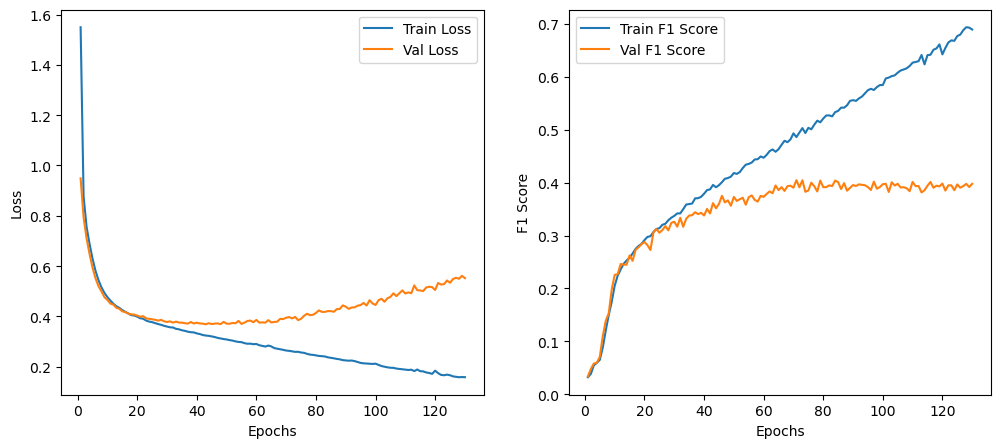

In [15]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()